In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import os
import sys
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
#from scipy.spatial import SphericalVoronoi
#from sklearn.neighbors import BallTree
#import time
#sys.path.append('../hos_code')
from tunnel_finder import tunnel_finder
import urllib.request
from healpy.projector import MollweideProj
from matplotlib.collections import LineCollection

In [2]:
def get_takahashi(url, output_directory, output_filename):
    """
    Downloads and processes the a kappa map data file from Takahashi+ 2017, saving the processed data as a .fits file.

    Parameters
    ----------
    url : str
        The URL to download the Takahashi data file from.
    output_directory : str
        The directory where the downloaded and processed files will be saved.
    output_filename : str
        The name of the file to save the downloaded data as (without the .fits extension).

    Notes
    -----
    This function downloads the file from the specified URL if it does not already exist in the output directory.
    It then reads and processes the file, extracting specific data blocks and saving them into a .fits file.
    """
    
    download_path = f'{output_directory}/{output_filename}'
    if not os.path.exists(download_path):
        urllib.request.urlretrieve(url, download_path)

    filename = f'{output_directory}/{output_filename}'
    save_path = f'{output_directory}/{output_filename}.fits'
    
    if not os.path.exists(save_path):
        skip = [0, 536870908, 1073741818, 1610612728, 2147483638, 2684354547, 3221225457]
        load_blocks = [skip[i+1]-skip[i] for i in range(0, 6)]

        with open(filename, 'rb') as f:
            rec = np.fromfile(f, dtype='uint32', count=1)[0]
            nside = np.fromfile(f, dtype='int32', count=1)[0]
            npix = np.fromfile(f, dtype='int64', count=1)[0]
            rec = np.fromfile(f, dtype='uint32', count=1)[0]
            print("nside:{} npix:{}".format(nside, npix))

            rec = np.fromfile(f, dtype='uint32', count=1)[0]

            kappa = np.array([])
            r = npix
            for i, l in enumerate(load_blocks):
                blocks = min(l, r)
                load = np.fromfile(f, dtype='float32', count=blocks)
                np.fromfile(f, dtype='uint32', count=2)
                kappa = np.append(kappa, load)
                r = r-blocks
                if r == 0:
                    break
                elif r > 0 and i == len(load_blocks)-1:
                    load = np.fromfile(f, dtype='float32', count=r)
                    np.fromfile(f, dtype='uint32', count=2)
                    kappa = np.append(kappa, load)
        
        hp.fitsfunc.write_map(save_path, kappa)



def plot_healpix_with_fast_circles(
    hpx_map,
    circle_centers,
    circle_radii,
    title=None,  # Optional title
    coord='G',
    num_points=30,
    scatter_points=None,
    scatter_style=dict(marker='o', s=10, color='black'),
    circle_style=dict(color='red', linewidth=0.5),
    save_path=None
):
    def get_circle_coords(lon_c, lat_c, radius_deg, num_points):
        lon_c = np.radians(lon_c)
        lat_c = np.radians(lat_c)
        radius = np.radians(radius_deg)
        theta = np.linspace(0, 2 * np.pi, num_points)
        lat = np.arcsin(np.sin(lat_c) * np.cos(radius) +
                        np.cos(lat_c) * np.sin(radius) * np.cos(theta))
        lon = lon_c + np.arctan2(np.sin(theta) * np.sin(radius) * np.cos(lat_c),
                                 np.cos(radius) - np.sin(lat_c) * np.sin(lat))
        return lon, lat

    # Normalize input
    circle_centers = np.asarray(circle_centers)
    if circle_centers.shape[0] == 2 and circle_centers.shape[1] != 2:
        circle_centers = circle_centers.T
    if circle_centers.shape[1] != 2:
        raise ValueError("circle_centers must be (N, 2) shaped")

    fig = plt.figure(figsize=(10, 6))
    # Create map without colorbar and without 'Galactic' label
    hp.mollview(
        hpx_map,
        title='',              # suppress built-in title
        coord=coord,
        hold=True,
        cbar=False,            # turn off colorbar
        notext=True            # turn off 'Galactic' label
    )
    ax = plt.gca()
    proj = MollweideProj(rot=None, coord=coord, xsize=800)

    # === Compute data-driven wrap threshold ===
    max_radius_deg = np.max(circle_radii)
    max_radius_rad = np.radians(max_radius_deg)
    expected_segment_arc = 2 * max_radius_rad * np.sin(np.pi / num_points)
    wrap_threshold_proj = 2.5 * (2 * np.sqrt(2) * expected_segment_arc / np.pi)

    all_segments = []
    for (lon, lat), radius in zip(circle_centers, circle_radii):
        lon_circ, lat_circ = get_circle_coords(lon, lat, radius, num_points)

        theta = np.pi / 2 - lat_circ
        phi = lon_circ
        vec = np.array(hp.ang2vec(theta, phi)).T
        x, y = proj.vec2xy(vec[0], vec[1], vec[2])
        circle_points = np.column_stack((x, y))

        for i in range(len(circle_points)):
            p1 = circle_points[i]
            p2 = circle_points[(i + 1) % len(circle_points)]
            dx = abs(p1[0] - p2[0])
            if dx < wrap_threshold_proj:
                all_segments.append(np.array([p1, p2]))

    line_collection = LineCollection(all_segments, **circle_style)
    ax.add_collection(line_collection)

    # Optional scatter overlay
    if scatter_points is not None:
        scatter_points = np.asarray(scatter_points)
        if scatter_points.shape[0] == 2 and scatter_points.shape[1] != 2:
            scatter_points = scatter_points.T
        if scatter_points.shape[1] != 2:
            raise ValueError("scatter_points must be (N, 2) shaped")

        lons, lats = scatter_points[:, 0], scatter_points[:, 1]
        theta = np.radians(90 - lats)
        phi = np.radians(lons)
        vec = np.array(hp.ang2vec(theta, phi)).T
        x, y = proj.vec2xy(vec[0], vec[1], vec[2])
        ax.scatter(x, y, **scatter_style)

    # Optional title
    if title:
        ax.set_title(title)

    if save_path:
        plt.savefig(save_path, dpi=150)
        plt.close()
    else:
        plt.show()

In [3]:
#Alternatively, you can remove this and load your own map. 
url = 'http://cosmo.phys.hirosaki-u.ac.jp/takahasi/allsky_raytracing/sub1/nres12/allskymap_nres12r000.zs16.mag.dat' #update this if you want a different map from T17
output_directory = '/project/ls-mohr/users/c.davies/data/' #update this
output_filename = 'test_data' #update this

In [4]:
#get_takahashi(url, output_directory, output_filename)
#uncomment above if you need to download a test map

In [5]:
#load data

sl = 60. #arcmin. Large smoothing scale for speed

kappa_map = hp.read_map(output_directory+output_filename+'.fits')
kappa_map = hp.ud_grade(kappa_map, 1024) #downgrade the resolution to increase speed in the example notebook

kappa_map = hp.smoothing(kappa_map, sigma = sl / 60. / 180.*np.pi    )

#make mask to use and exemplify the full functionality of the code if work on real data is needed
nside = hp.get_nside(kappa_map)
npix = hp.nside2npix(nside)
phi, theta = hp.pix2ang(nside ,range(npix))
phi_filter = phi > np.pi / 2
theta_filter = theta > np.pi / 2
mask = np.logical_or(phi_filter, theta_filter)

#create two version of the map, one with a mask and one without
kappa_map_with_mask = np.copy(kappa_map)
kappa_map_with_mask[mask] = hp.UNSEEN

#tunnel_finder is an object that manages the map and subsequent extrema and tunnel catalogues. 
tunnel_finder_no_mask = tunnel_finder(kappa_map, smooth=True, map_has_mask=False, lonlat=True) #lonlat should always be true with this code, lonlat=False is buggy in this version
tunnel_finder_with_mask = tunnel_finder(kappa_map_with_mask, smooth=True, map_has_mask=True, lonlat=True)
#smooth flag tells the tunnel_finder whether or not that map has been smoothed
#map_has_mask flag tells the code if the map has a mask
#lonlat sets the coordinate system for the code to use. It should always be True. 

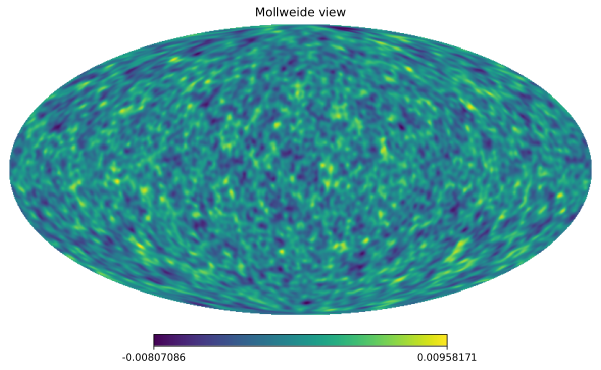

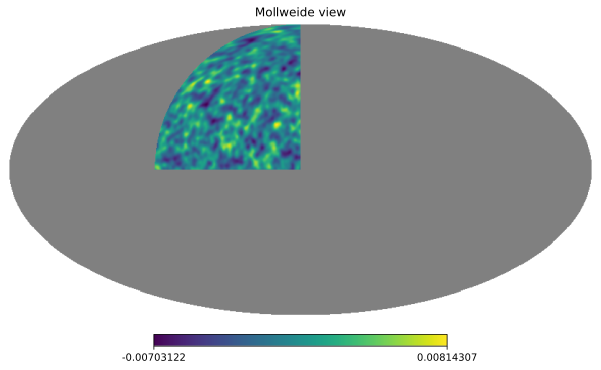

In [6]:
hp.mollview(tunnel_finder_no_mask.get_assigned_kappa_map())
hp.mollview(tunnel_finder_with_mask.get_assigned_kappa_map())

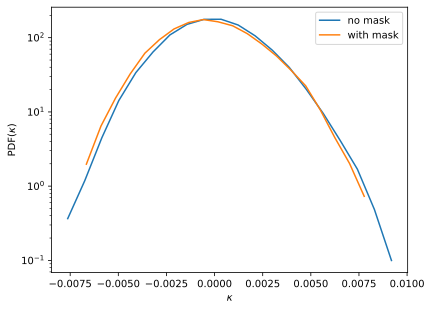

In [7]:
#measure and plot convergence pdf.
#tunnel_finder object can measure pdf for you, but you can also compute this manually
pdf, pdf_binMid = tunnel_finder_no_mask.get_pdf()
plt.semilogy(pdf_binMid,pdf, label = 'no mask')
#plt.show()

#measure and plot convergence pdf
pdf, pdf_binMid = tunnel_finder_with_mask.get_pdf()
plt.semilogy(pdf_binMid,pdf, label = 'with mask')

plt.legend()
plt.xlabel(r'$\kappa$')
plt.ylabel(r'PDF($\kappa$)')
plt.show()

In [8]:
#find peaks and minima, find_extrema method returns positions and amplitudes
peak_pos_no_mask, peak_height_no_mask = tunnel_finder_no_mask.find_extrema() #find_extrema method identifies peaks by default
minima_pos, minima_height = tunnel_finder_no_mask.find_extrema(minima=True) #tell find_extrema method to find minima instead

#find peaks and minima
peak_pos_with_mask, peak_height_with_mask = tunnel_finder_with_mask.find_extrema()
minima_pos, minima_height = tunnel_finder_with_mask.find_extrema(minima=True)

finding peaks
number of peaks identified: 1450
calculating extrema positions and amplitudes
done
finding minima
number of minima identified: 1408
calculating extrema positions and amplitudes
done
finding peaks
number of peaks identified: 201
calculating extrema positions and amplitudes
done
finding minima
number of minima identified: 191
calculating extrema positions and amplitudes
done


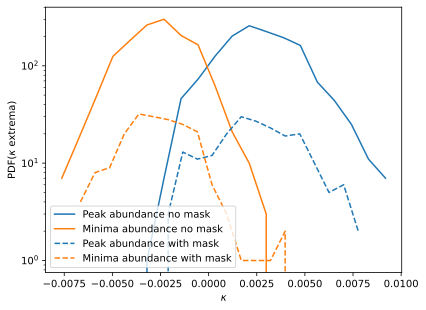

In [9]:
#plot peak and minima abundances
#tunnel_finder object can measure peak and minima abundance for you, but you can also compute this manually
PA, PA_binMid = tunnel_finder_no_mask.get_extrema_abundance()
MA, MA_binMid = tunnel_finder_no_mask.get_extrema_abundance(minima=True)

plt.semilogy(PA_binMid,PA,label='Peak abundance no mask', color='C0')
plt.semilogy(MA_binMid,MA,label='Minima abundance no mask', color='C1')

PA, PA_binMid = tunnel_finder_with_mask.get_extrema_abundance()
MA, MA_binMid = tunnel_finder_with_mask.get_extrema_abundance(minima=True)

plt.semilogy(PA_binMid,PA,label='Peak abundance with mask', color='C0', linestyle = '--')
plt.semilogy(MA_binMid,MA,label='Minima abundance with mask', color='C1', linestyle = '--')


plt.legend()
plt.legend()
plt.xlabel(r'$\kappa$')
plt.ylabel(r'PDF($\kappa$ extrema)')
plt.show()

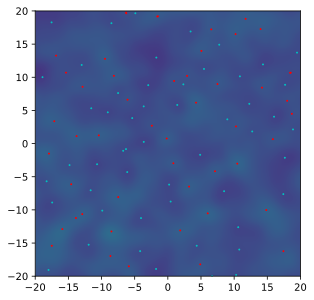

In [10]:
#plot minima and peaks on top of convergence map
size = 40 #angular exten of map to plot
npix = 512 #projected resolution
center = [60,60] #center of projection
tunnel_finder_no_mask.preview(size,npix,center,features=['peaks','minima']) #you can turn peaks and minima on and off in the plotting

In [11]:
#find the WL voids
#overlap flag determines whether or not output voids are allowed to contain additional smaller void centers.
#trim_boundary flag removes voids that intercept with mask boundary
#as an alternative to the trim_boundary flag, we can use the mask_fraction flag, 
#mask_fraction sets how much masked area a void is allowed to contain before being discarded
#angle_trim removes voids that correspond to Delaunay triangles with a smallest angle below the given value. Voids from long triangles are undesirable

void_pos_no_mask, void_rad_no_mask = tunnel_finder_no_mask.find_tunnels(overlap=False, trim_boundary=False, angle_trim=20)

void_pos_with_mask, void_rad_with_mask = tunnel_finder_with_mask.find_tunnels(overlap=False, trim_boundary=True, angle_trim=20)

void_pos_with_mask_fraction, void_rad_with_mask_fraction  = tunnel_finder_with_mask.find_tunnels(overlap=False, trim_mask_frac=0.3, angle_trim=20)

peak position shape: (1450, 2)
calculating point vectors
constructing Voronoi tesselation
calculating circumcenter angular positions
2896 voids found
constructing peak position balltree
sorting voids
trimming small angle voids
209 voids with small angles
trimming overlapping voids


1019it [00:00, 7167.37it/s]


1668 overlapping voids removed
1019 voids in final catalogue
peak position shape: (201, 2)
calculating point vectors
constructing Voronoi tesselation
calculating circumcenter angular positions
398 voids found
constructing peak position balltree
sorting voids
trimming boundary voids
109 voids near mask boundary
trimming small angle voids
32 voids with small angles
trimming overlapping voids


103it [00:00, 11292.69it/s]

154 overlapping voids removed
103 voids in final catalogue
peak position shape: (201, 2)
calculating point vectors
constructing Voronoi tesselation
calculating circumcenter angular positions
398 voids found
constructing peak position balltree
sorting voids
trimming mask fraction


56 mask fraction voids removed
trimming small angle voids
37 voids with small angles
trimming overlapping voids


114it [00:00, 10007.13it/s]

191 overlapping voids removed
114 voids in final catalogue


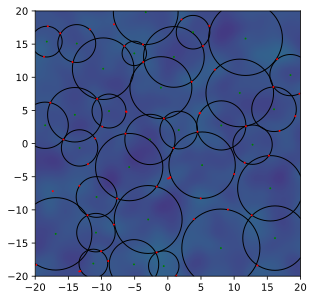

In [12]:
#plot the voids and peaks on the convergence map
size = 40  #note that distortions should be expected if projecting large areas. Not accounted for here, but are captured in full sky plot below
npix = 512
center = [0,60]

tunnel_finder_no_mask.preview(size,npix,center,features=['peaks','voids'])

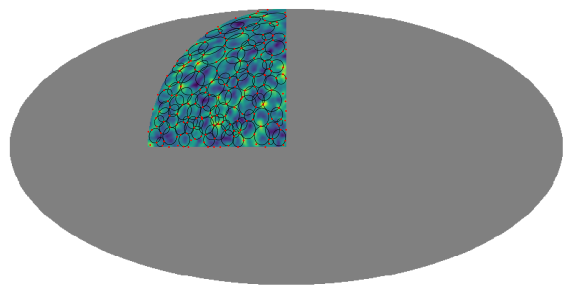

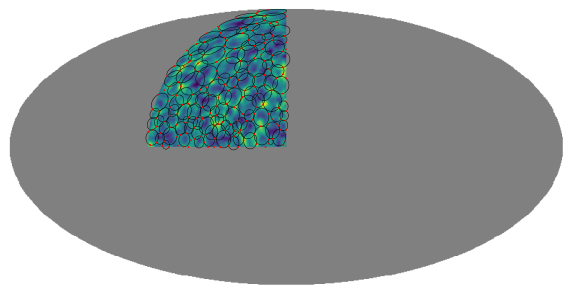

In [13]:
#you can also visualise the whole map with the following function and code
plot_healpix_with_fast_circles(
        hpx_map=tunnel_finder_no_mask.get_assigned_kappa_map(),
        circle_centers=void_pos_no_mask,
        circle_radii=void_rad_no_mask,
        title=None,
        scatter_points=peak_pos_no_mask,
        scatter_style=dict(marker='.', s=3, color='red', zorder=1),
        circle_style=dict(color='black', linewidth=0.5, zorder=0),
        num_points = 20,
    )
plt.show()

plot_healpix_with_fast_circles(
        hpx_map=tunnel_finder_with_mask.get_assigned_kappa_map(),
        circle_centers=void_pos_with_mask,
        circle_radii=void_rad_with_mask,
        title=None,
        scatter_points=peak_pos_with_mask,
        scatter_style=dict(marker='.', s=3, color='red', zorder=1),
        circle_style=dict(color='black', linewidth=0.5, zorder=0),
        num_points = 20,
    )
plt.show()

plot_healpix_with_fast_circles(
        hpx_map=tunnel_finder_with_mask.get_assigned_kappa_map(),
        circle_centers=void_pos_with_mask_fraction,
        circle_radii=void_rad_with_mask_fraction,
        title=None,
        scatter_points=peak_pos_with_mask,
        scatter_style=dict(marker='.', s=3, color='red', zorder=1),
        circle_style=dict(color='black', linewidth=0.5, zorder=0),
        num_points = 20,
    )
plt.show()

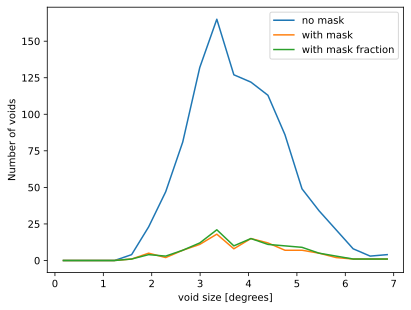

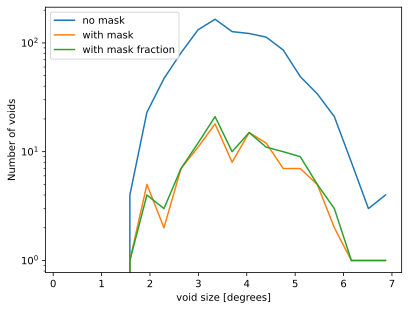

In [14]:
#plot the WL void abundances in log and linear space
nbins = 20
binEdges = np.linspace(0,void_rad_no_mask.max(),nbins+1)
binMid = 0.5 * (binEdges[1:] + binEdges[:-1])

void_rad_dist_no_mask, discard = np.histogram(void_rad_no_mask,binEdges)
void_rad_dist_with_mask, discard = np.histogram(void_rad_with_mask,binEdges)
void_rad_dist_with_mask_fraction, discard = np.histogram(void_rad_with_mask_fraction,binEdges)

plt.plot(binMid,void_rad_dist_no_mask, label='no mask')
plt.plot(binMid,void_rad_dist_with_mask, label='with mask')
plt.plot(binMid,void_rad_dist_with_mask_fraction, label='with mask fraction')
plt.xlabel('void size [degrees]')
plt.ylabel('Number of voids')
plt.legend()
plt.show()

plt.semilogy(binMid,void_rad_dist_no_mask, label='no mask')
plt.semilogy(binMid,void_rad_dist_with_mask, label='with mask')
plt.semilogy(binMid,void_rad_dist_with_mask_fraction, label='with mask fraction')
plt.xlabel('void size [degrees]')
plt.ylabel('Number of voids')
plt.legend()
plt.show()

In [15]:
r_min = 0
r_max = 2
nbins = 50
r_mid, kappa_profile_no_mask = tunnel_finder_no_mask.get_profiles(nbins,r_min,r_max,void_pos_no_mask,void_rad_no_mask)

r_min = 0
r_max = 2
nbins = 50
r_mid, kappa_profile_with_mask = tunnel_finder_with_mask.get_profiles(nbins,r_min,r_max,void_pos_with_mask,void_rad_with_mask)

r_min = 0
r_max = 2
nbins = 50
r_mid, kappa_profile_with_mask_fraction = tunnel_finder_with_mask.get_profiles(nbins,r_min,r_max,void_pos_with_mask_fraction,void_rad_with_mask_fraction)

100%|██████████| 1019/1019 [00:15<00:00, 66.58it/s] 


taking weighted average


100%|██████████| 103/103 [00:01<00:00, 59.27it/s]


taking weighted average


100%|██████████| 114/114 [00:01<00:00, 58.36it/s]

taking weighted average


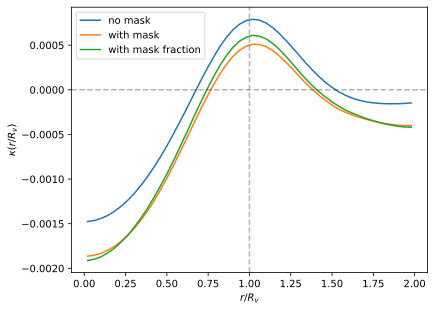

In [16]:
plt.plot(r_mid,kappa_profile_no_mask, label = 'no mask')
plt.plot(r_mid,kappa_profile_with_mask, label = 'with mask')
plt.plot(r_mid,kappa_profile_with_mask_fraction, label = 'with mask fraction')

plt.axhline(y=0,linestyle='--',color='k', alpha=0.3)
plt.axvline(x=1,linestyle='--',color='k', alpha=0.3)


plt.ylabel(r'$\kappa(r/R_v)$')
plt.xlabel(r'$r/R_v$')
plt.legend()
plt.show()

Now we can repeat the above but with applying an amplitude cut to the peaks before using them to identify voids

In [17]:
#define the kappa thresholds to be applied to the peak catalogues before void finding
thresholds = [0] #this can be a list, e.g. [0,0.01]. good threshold choices will depend on width of kappa pdf
tunnel_finder_with_mask.get_peak_catalogues( thresholds = thresholds )

In [18]:
#find the WL void catalogues associated with the peak catalogues
void_pos_cat, void_rad_cat = tunnel_finder_with_mask.get_tunnel_catalogues(overlap=False, trim_mask_frac=0.3, angle_trim=20)

#the outputs are lists of the position and amplitude catalogues for each threshold. 
#note you may need an extra list index as these are lists of lists due to a bug

peak position shape: (201, 2)
calculating point vectors
constructing Voronoi tesselation
calculating circumcenter angular positions
334 voids found
constructing peak position balltree
sorting voids
trimming mask fraction
50 mask fraction voids removed
trimming small angle voids
37 voids with small angles
trimming overlapping voids


97it [00:00, 10676.45it/s]

150 overlapping voids removed
97 voids in final catalogue


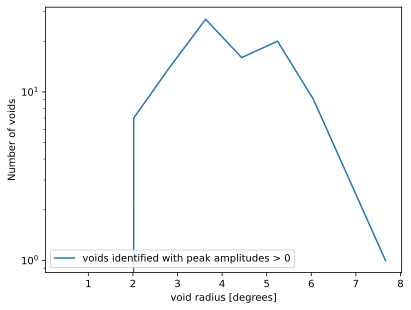

In [19]:
#plot the void abundances for the different void catalogues
nbins = 10

for i in range(len(thresholds)):
    binEdges = np.linspace(0,np.max(void_rad_cat[i]),nbins+1)
    binMid = 0.5 * (binEdges[1:] + binEdges[:-1])

    void_rad_dist, discard = np.histogram(void_rad_cat[i],binEdges)

    plt.semilogy(binMid,void_rad_dist, label=f'voids identified with peak amplitudes > {thresholds[i]}')
plt.xlabel('void radius [degrees]')
plt.ylabel('Number of voids')
plt.legend()
plt.show()

In [20]:
#to do
#CTH profile example
#local background subtraction
#example with discrete tracers as direct input from scratch

In [22]:
#you might want to measure the profiles of the voids in different maps
#for this you can compute cross profiles, by supplying a cross map directly.
#in this case we still use a kappa map, but you can replace this with any healpix map, e.g. a CMB map. 
test_map = np.copy(kappa_map) #duplicate the map you are supplying, otherwise it gets overwritten when transformed if cross_kappa = True. 


#if cross_kappa is True, the map is not transformed
r_mid, kappa_profile_cross_1 = tunnel_finder_no_mask.get_profiles_cross_map(kappa_map, nbins,r_min,r_max,void_pos_no_mask,void_rad_no_mask, cross_kappa=True)
#if cross_kappa is False, the map is transformed by subtracting the mean and then dividing by the mean
r_mid, kappa_profile_cross_2 = tunnel_finder_no_mask.get_profiles_cross_map(test_map, nbins,r_min,r_max,void_pos_no_mask,void_rad_no_mask, cross_kappa=False)


#You might also want to compute the compensated top hat filtered profile, which is exemplified below
r_mid, kappa_profile_CTH = tunnel_finder_no_mask.get_profiles_cross_map_CTHFilter(kappa_map,nbins,r_min,r_max,void_pos_no_mask,void_rad_no_mask)

#Finally, you can also perform a local background subtraction at the final annular bin. You can modify tunnel_finder.py if you want to perform a local background subtraction elsewhere. 
r_mid, kappa_profile_lbs = tunnel_finder_no_mask.get_profiles_cross_map(kappa_map,nbins,r_min,r_max,void_pos_no_mask,void_rad_no_mask, cross_kappa=True, local_background_subtraction = True)


cross kappa flag = True
pixel area = 1
local background subtraction = False
cross map mean = 4.809091025772915e-08
cross map median = -5.593434591881561e-05
mean after scaling = 4.809091025772915e-08


100%|██████████| 1019/1019 [00:03<00:00, 293.72it/s]


taking weighted average
cross map mean = 4.809091025772915e-08
cross kappa flag = False
pixel area = 0.0032784908016061202
local background subtraction = False
cross map mean = 4.809091025772915e-08
cross map median = -5.593434591881561e-05
creating overdensity map
mean after scaling = -1.7482311894430798e-12


100%|██████████| 1019/1019 [00:03<00:00, 292.94it/s]


taking weighted average
cross map mean = 4.809091025772915e-08


100%|██████████| 1019/1019 [00:06<00:00, 153.47it/s]


cross kappa flag = True
pixel area = 1
local background subtraction = True
cross map mean = 4.809091025772915e-08
cross map median = -5.593434591881561e-05
mean after scaling = 4.809091025772915e-08


100%|██████████| 1019/1019 [00:04<00:00, 229.36it/s]

subtracting local means: [[ 0.00016311  0.00016311  0.00016311 ...  0.00016311  0.00016311
   0.00016311]
 [ 0.00029751  0.00029751  0.00029751 ...  0.00029751  0.00029751
   0.00029751]
 [-0.00059767 -0.00059767 -0.00059767 ... -0.00059767 -0.00059767
  -0.00059767]
 ...
 [-0.00193679 -0.00193679 -0.00193679 ... -0.00193679 -0.00193679
  -0.00193679]
 [-0.00179583 -0.00179583 -0.00179583 ... -0.00179583 -0.00179583
  -0.00179583]
 [ 0.00027022  0.00027022  0.00027022 ...  0.00027022  0.00027022
   0.00027022]]
taking weighted average
cross map mean = 4.809091025772915e-08


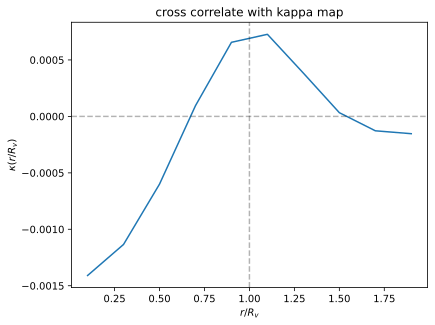

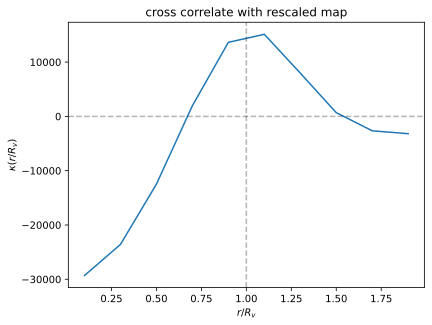

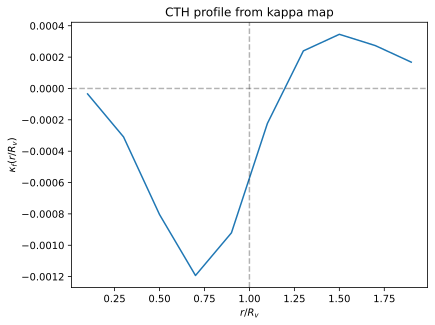

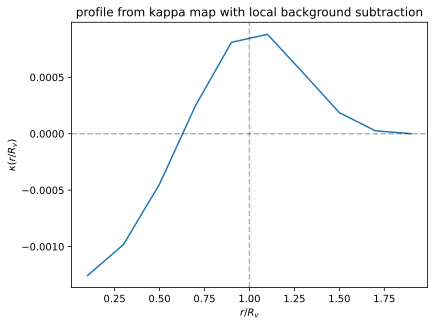

In [29]:
plt.plot(r_mid, kappa_profile_cross_1)
plt.axhline(y=0,linestyle='--',color='k',alpha=0.3)
plt.axvline(x=1,linestyle='--',color='k',alpha=0.3)
plt.xlabel(r'$r/R_v$')
plt.ylabel(r'$\kappa(r/R_v)$')
plt.title('cross correlate with kappa map')
plt.show()

plt.plot(r_mid, kappa_profile_cross_2)
plt.axhline(y=0,linestyle='--',color='k',alpha=0.3)
plt.axvline(x=1,linestyle='--',color='k',alpha=0.3)
plt.xlabel(r'$r/R_v$')
plt.ylabel(r'$\kappa(r/R_v)$')
plt.title('cross correlate with rescaled map')
plt.show()

plt.plot(r_mid, kappa_profile_CTH)
plt.axhline(y=0,linestyle='--',color='k',alpha=0.3)
plt.axvline(x=1,linestyle='--',color='k',alpha=0.3)
plt.xlabel(r'$r/R_v$')
plt.ylabel(r'$\kappa_f(r/R_v)$')
plt.title('CTH profile from kappa map')
plt.show()

plt.plot(r_mid, kappa_profile_lbs)
plt.axhline(y=0,linestyle='--',color='k',alpha=0.3)
plt.axvline(x=1,linestyle='--',color='k',alpha=0.3)
plt.xlabel(r'$r/R_v$')
plt.ylabel(r'$\kappa(r/R_v)$')
plt.title('profile from kappa map with local background subtraction')
plt.show()

peak position shape: (201, 2)
calculating point vectors
constructing Voronoi tesselation
calculating circumcenter angular positions
398 voids found
constructing peak position balltree
sorting voids
trimming mask fraction
56 mask fraction voids removed
trimming small angle voids
37 voids with small angles
trimming overlapping voids
305 voids in final catalogue


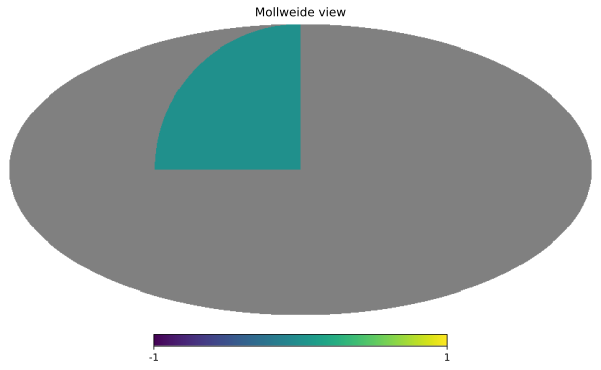

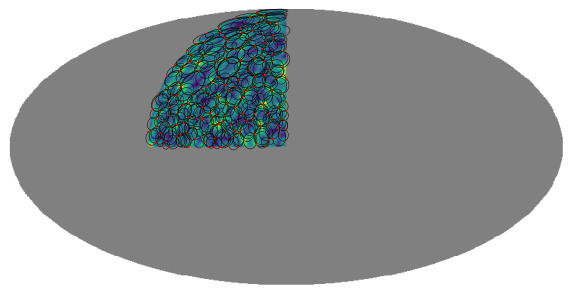

In [34]:
#alternatively you can give a tracer catalogue directly to the void finder
test_map = np.zeros([hp.nside2npix(1024)])
test_map[mask] = hp.UNSEEN
test_map = hp.ma(test_map)
hp.mollview(test_map)


cosmic_tunnels = tunnel_finder(test_map.data, map_has_mask = True)

void_pos, void_rad, void_boundary_points = cosmic_tunnels.find_tunnels(peak_pos = peak_pos_with_mask, overlap=True, 
                                                     trim_mask_frac = 0.3, angle_trim = 20, 
                                                     return_boundary_points = True)
#note: return boundary points gives the three tracers associated with each void


plot_healpix_with_fast_circles(
        hpx_map=tunnel_finder_with_mask.get_assigned_kappa_map(),
        circle_centers=void_pos,
        circle_radii=void_rad,
        title=None,
        scatter_points=peak_pos_with_mask,
        scatter_style=dict(marker='.', s=3, color='red', zorder=1),
        circle_style=dict(color='black', linewidth=0.5, zorder=0),
        num_points = 20,
    )
plt.show()